# Evaluating a CellPose2 model

In this notebook, we will take predictions from our model_training notebook to compare with the ground truth data to showcase how to evaluate how a cell segmenting model performs.

Our data is pictures of cells and masks. The masks each segment multiple cells of the images and give each cell its own color code

## Individually segmenting out the cells

This process follows the following method:
    &nbsp;&nbsp;&nbsp;&nbsp;get the pixel values that are in the predicted mask (0 is the background)
    &nbsp;&nbsp;&nbsp;&nbsp;for each pixel value
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;get its 4 corners
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;calculate its longest diagonal
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;use it to create a bounding box around the cell
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;store the coordinates of that bounding box
    &nbsp;&nbsp;&nbsp;&nbsp;apply all of the bounding boxes around the original image to see if it retrieves the nuclei

In [1]:
#Load the model and data
from cellpose import models, io, metrics
model = models.CellposeModel(gpu=True,
                             pretrained_model='C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model')
train_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training"
test_dir = "C:/Users/rz200/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_testing"

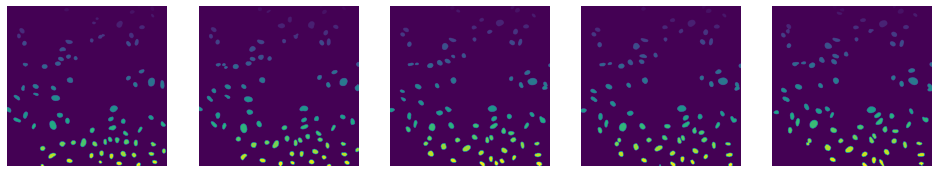

In [12]:
#Here we use the model to make predictions
#I need to add comments to this
import matplotlib.pyplot as plt

channels = [0,0] #first 0: grayscale; second 0: None
diam_labels = model.diam_labels.copy() #diameter of labels in training images
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]
predicted_test_masks = model.eval(test_data,
                                  channels=channels,
                                  diameter=diam_labels)[0]
#Displaying the predictions
plt.figure(figsize=(20,20))
for i in range(len(predicted_test_masks)):
    plt.subplot(1,len(predicted_test_masks)+1,i+1)
    plt.axis('off')
    plt.imshow(predicted_test_masks[i])
plt.show()

In [3]:
#Here we qualitatively compare these predictions with the ground truth masks
ap = metrics.average_precision(test_labels, predicted_test_masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


>>> average precision at iou threshold 0.5 = 0.823


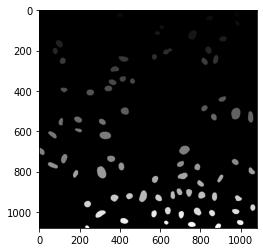

In [20]:
import matplotlib.pyplot as plt

plt.imshow(predicted_test_masks[0],cmap='gray')

In [234]:
import crop_cells
import importlib
importlib.reload(crop_cells)

<module 'crop_cells' from 'C:\\Users\\rz200\\Documents\\Development\\cell-SCT\\segmentation\\crop_cells.py'>

In [265]:
importlib.reload(crop_cells)
from crop_cells import count_cells

#print(count_cells(predicted_test_masks[0]))
print(count_cells(predicted_test_masks[0]))

79


In [266]:
from crop_cells import get_img_crops, get_cell_crop_coordinates


crop_coordinates = get_cell_crop_coordinates(predicted_test_masks[0])


crops_test = get_img_crops(test_data[0], crop_coordinates)


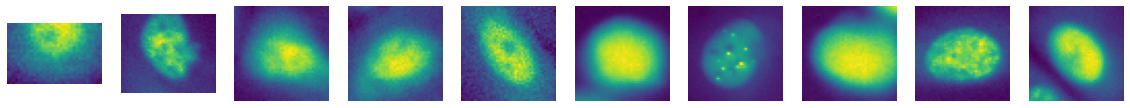

In [267]:
from crop_cells import get_img_crops, get_cell_crop_coordinates
crop_coordinates = get_cell_crop_coordinates(predicted_test_masks[0])
crops_test = get_img_crops(test_data[0], crop_coordinates)

plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(crops_test[i])
    plt.axis('off')
plt.show()

In [217]:
#Function that takes an image, its ground truth mask and its predicted mask and output the comparison between the cropped cells it made
#It should also output the number of cells found by each (later on this should be a measure metric)
def match_cell_crops(original_img, gt_mask, pred_mask):
    #Get the crops for the gt mask and the pred mask
    gt_crops = get_img_crops(original_img,get_cell_crop_coordinates(gt_mask)) #lets try and speed up this function

    pred_crops = get_img_crops(original_img,get_cell_crop_coordinates(pred_mask))
    #Sort them to see which correspond to which

    ious = metrics.mask_ious(gt_mask,pred_mask)

    #Match them up into pairs
    pairs = [(gt_crops[i],pred_crops[ious[1][i]-1]) if ious[1][i]-1 != -1 else (gt_crops[i],[0]) for i in range(len(ious[1]))]

    return pairs

In [275]:
def display_pairs(pairs,ious=None,order="normal",filter=None):
    #we'll add a sorting method later that sorts by most similar to most dissimilar pairs
    #open up pairs_test to just be a sequential list, no tuples
    #for comparison, print the coordinates of the center of the crop relative to the original img to show how far away these two crops are, we might use that distance as a threshold for matching them up
    #lets add this function to the py file
    #lets make a function that calculates the distance between two crops

    #add some sorting to the pairs
    #first kind should be "normal"
    #second kind should be "most different"
    #third kind should be "most similar"
    #fourth kind should be "only matched"
    #fifth kind should be "only non-matched"
    #pairs = np.array(pairs)


    if ious is not None and filter is not None:
        if filter == 'only_matched':
            pairs_kept = []
            for i in range(len(pairs)):
                if ious[0][i] != 0: pairs_kept.append(pairs[i])
            pairs = pairs_kept
        if filter == 'only_non_matched':
            pairs_kept = []
            for i in range(len(pairs)):
                if ious[0][i] == 0: pairs_kept.append(pairs[i])
            pairs = pairs_kept

    if ious is not None and order != "normal":
        pairs = [pair for _,pair in sorted(zip(ious[0],pairs), key=lambda first: first[0])] #sorted from lowest similarity to highest similarity
        if order == 'most_similar': pairs.reverse()






    pairs_seq = []
    for pair in pairs:
        pairs_seq.append(pair[0])
        pairs_seq.append(pair[1])



    #print(pairs_seq[7]==pairs[3][1])
    #This plotting, for 84 images, takes 3 seconds (the rest of this function takes 0s)
    plt.figure(figsize=(2,len(pairs_seq)))
    for i in range(0,len(pairs_seq),2):
        plt.subplot(int(len(pairs_seq)/2),2,i+1)
        plt.imshow(pairs_seq[i])
        plt.axis('off')
        plt.subplot(int(len(pairs_seq)/2),2,i+2)
        #print(pairs_seq[i+1])
        if np.array(pairs_seq[i+1]).all() != 0:
            plt.imshow(pairs_seq[i+1])
        plt.axis('off')
    plt.show()

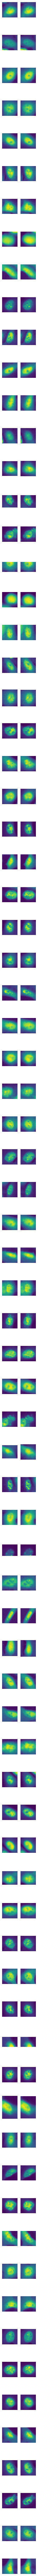

Execution time: 2.9441747665405273 seconds


In [274]:
ori_img = test_data[0]
gt_label = test_labels[0]
pred_label = predicted_test_masks[0]
ious = metrics.mask_ious(gt_label,pred_label)
sort = 'most_different'
filter = 'only_matched'
pairs = match_cell_crops(ori_img,gt_label,pred_label)


display_pairs(pairs,ious,sort,filter)


In [152]:
sorted_l = sorted(zip(pairs,ious[0]))

C:\Users\rz200\AppData\Local\Temp\ipykernel_14852\2662690768.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  sorted_l = sorted(zip(pairs,ious[0]))


ValueError: operands could not be broadcast together with shapes (45,56) (27,42) 

In [174]:
zipped = sorted(zip(ious[0],pairs), key=lambda first: first[0])
print(zipped)

[(0.0, (array([[2797, 2639, 2917, ..., 2410, 2388, 2387],
       [2861, 2752, 2826, ..., 2441, 2456, 2645],
       [2643, 2750, 2875, ..., 2519, 2368, 2480],
       ...,
       [3527, 3325, 3418, ..., 2328, 2398, 2374],
       [3317, 3392, 3351, ..., 2526, 2447, 2330],
       [3331, 3344, 3205, ..., 2321, 2320, 2385]], dtype=uint16), [0])), (0.0, (array([[3080, 3188, 3325, ..., 3191, 3210, 3199],
       [3119, 3108, 3357, ..., 3409, 3297, 3364],
       [3209, 3244, 3354, ..., 3480, 3441, 3304],
       ...,
       [3686, 3706, 3669, ..., 3707, 3775, 3750],
       [3767, 4018, 3827, ..., 3764, 3805, 3716],
       [3799, 3619, 3640, ..., 3639, 3725, 3727]], dtype=uint16), [0])), (0.0, (array([[2552, 2609, 2576, ..., 3063, 3027, 3159],
       [2575, 2533, 2611, ..., 3007, 3082, 3091],
       [2616, 2587, 2579, ..., 3167, 3199, 3174],
       ...,
       [2584, 2603, 2713, ..., 3400, 3387, 3356],
       [2751, 2542, 2525, ..., 3161, 3211, 3229],
       [2418, 2407, 2566, ..., 3183, 3203, 319

In [173]:
print(sortit)

[(0.0, (array([[2797, 2639, 2917, ..., 2410, 2388, 2387],
       [2861, 2752, 2826, ..., 2441, 2456, 2645],
       [2643, 2750, 2875, ..., 2519, 2368, 2480],
       ...,
       [3527, 3325, 3418, ..., 2328, 2398, 2374],
       [3317, 3392, 3351, ..., 2526, 2447, 2330],
       [3331, 3344, 3205, ..., 2321, 2320, 2385]], dtype=uint16), [0])), (0.0, (array([[3080, 3188, 3325, ..., 3191, 3210, 3199],
       [3119, 3108, 3357, ..., 3409, 3297, 3364],
       [3209, 3244, 3354, ..., 3480, 3441, 3304],
       ...,
       [3686, 3706, 3669, ..., 3707, 3775, 3750],
       [3767, 4018, 3827, ..., 3764, 3805, 3716],
       [3799, 3619, 3640, ..., 3639, 3725, 3727]], dtype=uint16), [0])), (0.0, (array([[2552, 2609, 2576, ..., 3063, 3027, 3159],
       [2575, 2533, 2611, ..., 3007, 3082, 3091],
       [2616, 2587, 2579, ..., 3167, 3199, 3174],
       ...,
       [2584, 2603, 2713, ..., 3400, 3387, 3356],
       [2751, 2542, 2525, ..., 3161, 3211, 3229],
       [2418, 2407, 2566, ..., 3183, 3203, 319

In [168]:
print(sorted(zip(list(ious[0]),list(pairs)))[0])

C:\Users\rz200\AppData\Local\Temp\ipykernel_14852\2596017104.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(sorted(zip(list(ious[0]),list(pairs)))[0])


ValueError: operands could not be broadcast together with shapes (40,40) (42,42) 

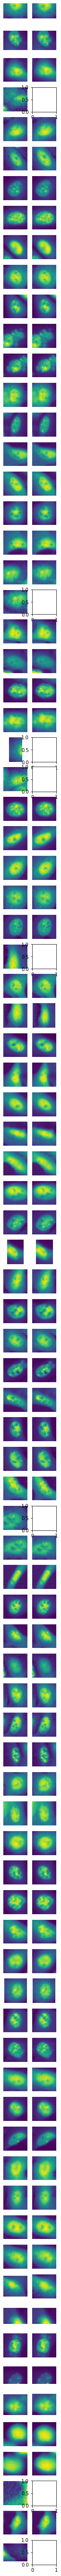

In [142]:
display_pairs(match_cell_crops(test_data[0],test_labels[0],predicted_test_masks[0]))

[0]
True


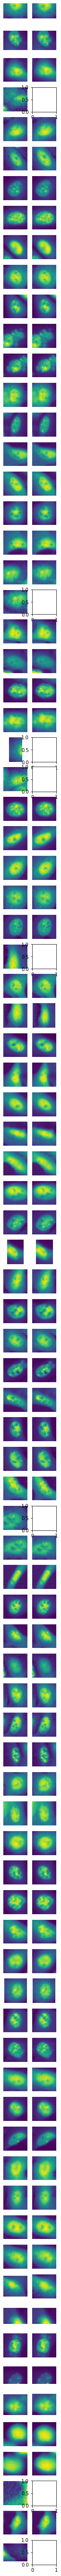

In [135]:
print(pairs[3][1])
display_pairs(pairs)

174


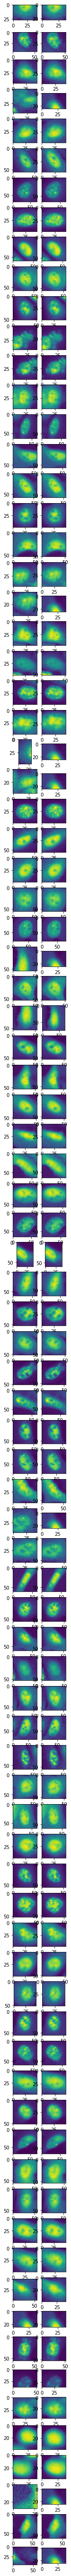

In [96]:
plt.figure(figsize=(2,100))
#open up pairs_test to just be a sequential list, no tuples
#for comapirson, print the coordinates of the center of the crop relative to the original img to show how far away these two crops are, we might use that distance as a threshold for matching them up
pairs_test_seq = []
for pair in pairs_test:
    pairs_test_seq.append(pair[0])
    pairs_test_seq.append(pair[1])

for i in range(0,len(pairs_test_seq),2):
    plt.subplot(int(len(pairs_test_seq)/2),2,i+1)
    plt.imshow(pairs_test_seq[i])
    #plt.axis('off')
    plt.subplot(int(len(pairs_test_seq)/2),2,i+2)
    plt.imshow(pairs_test_seq[i+1])
    #plt.axis('off')
plt.show()

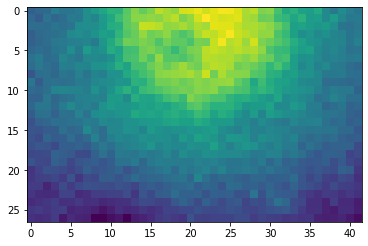

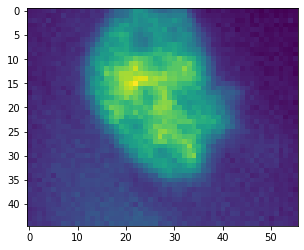

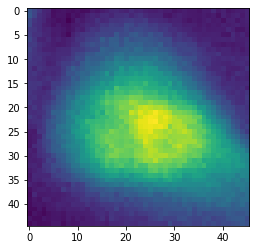

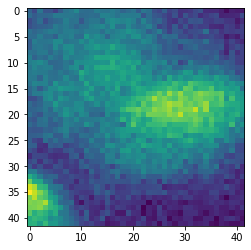

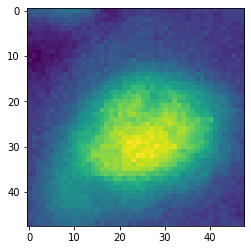

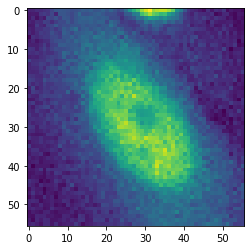

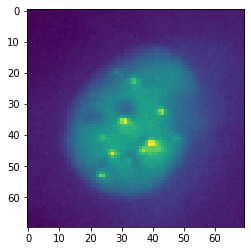

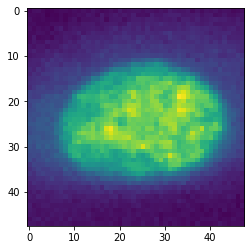

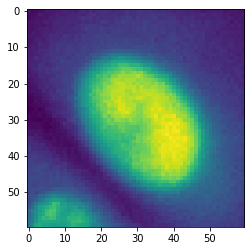

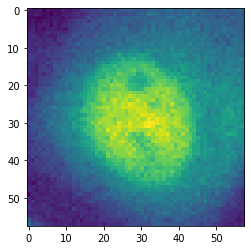

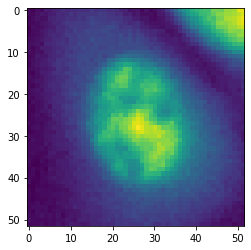

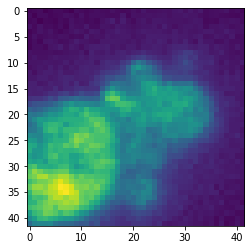

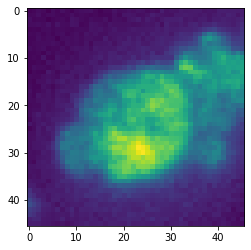

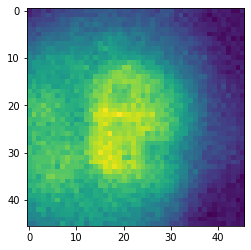

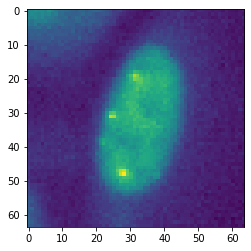

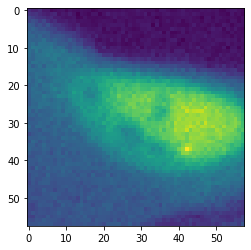

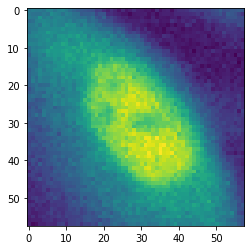

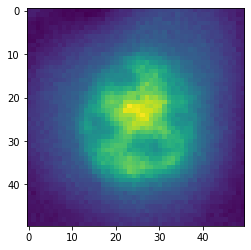

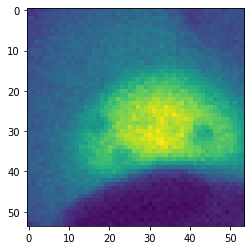

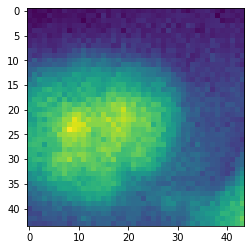

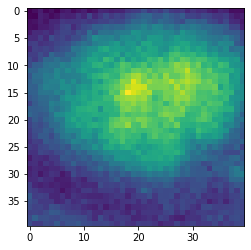

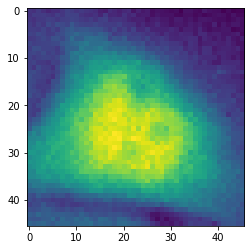

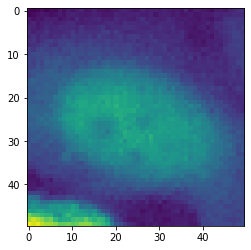

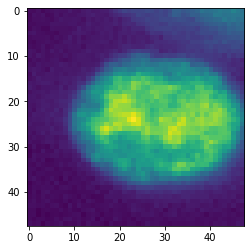

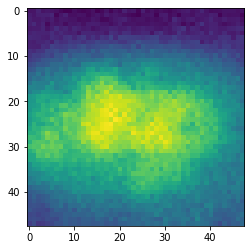

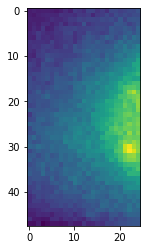

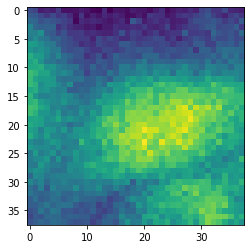

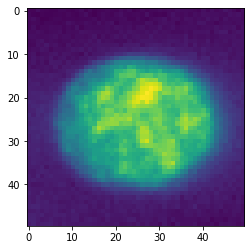

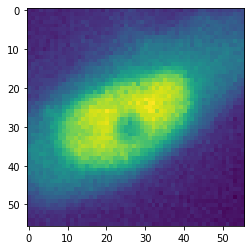

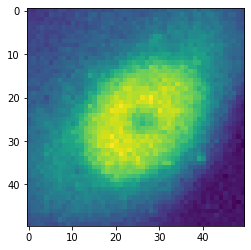

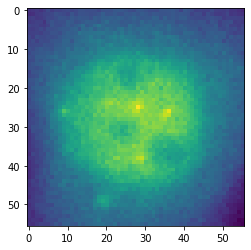

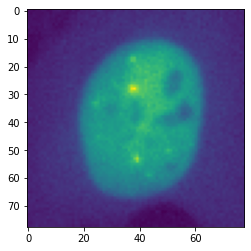

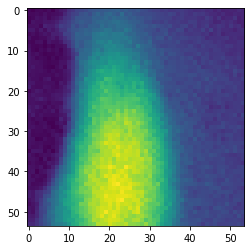

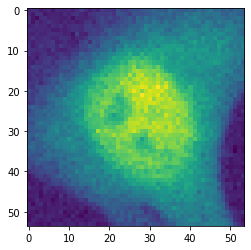

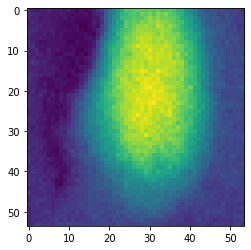

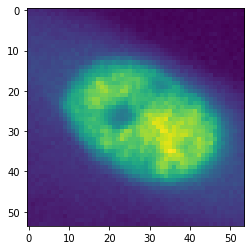

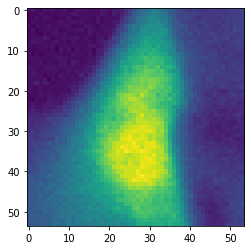

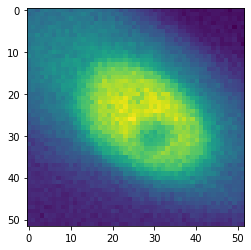

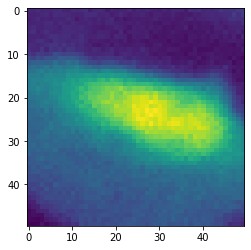

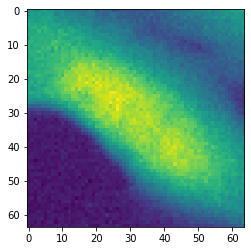

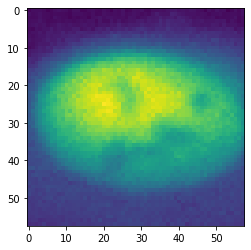

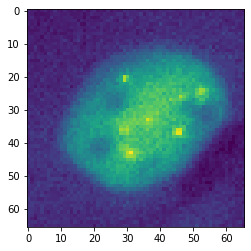

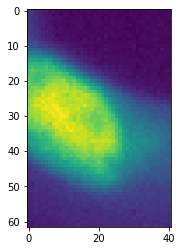

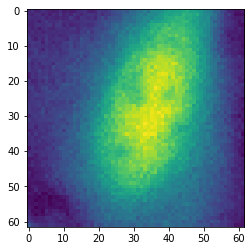

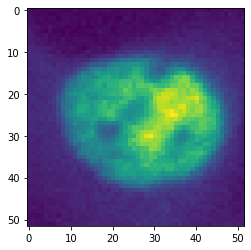

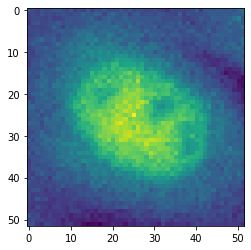

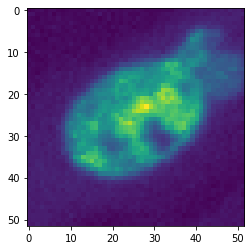

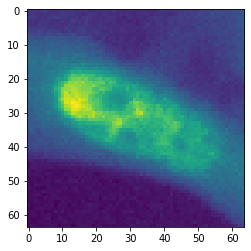

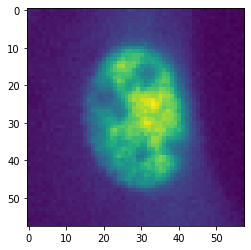

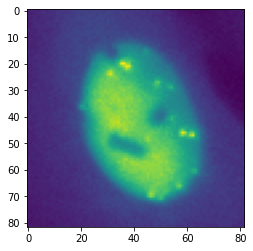

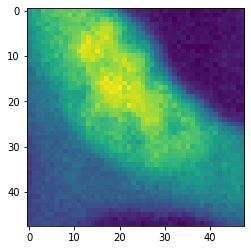

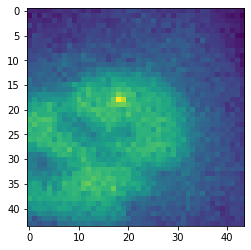

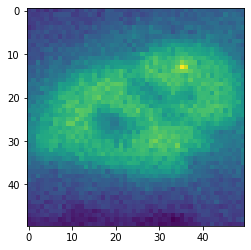

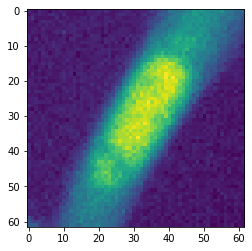

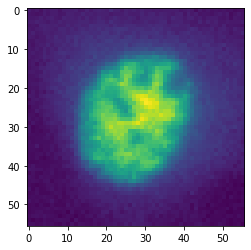

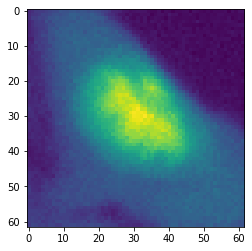

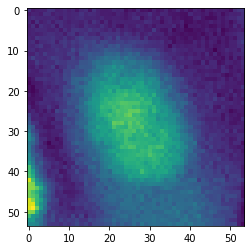

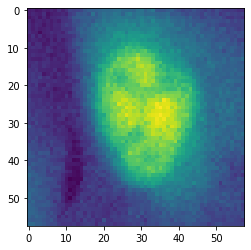

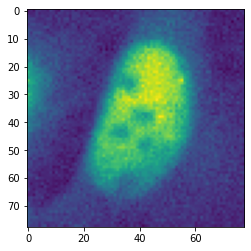

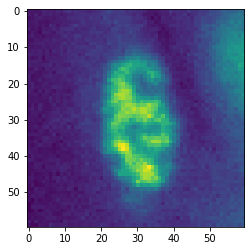

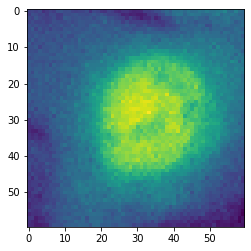

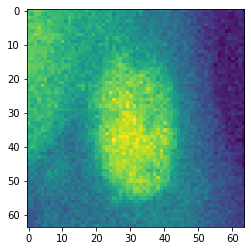

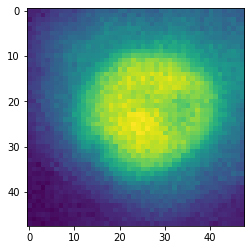

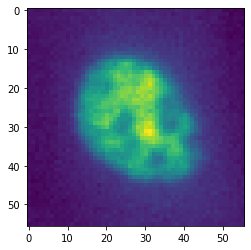

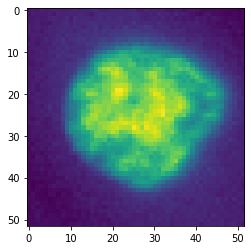

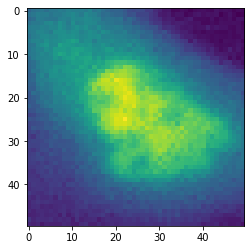

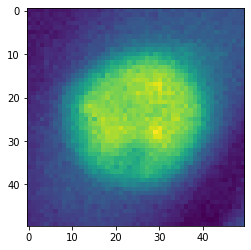

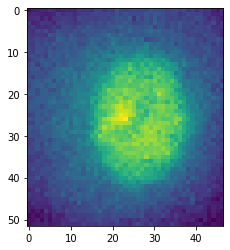

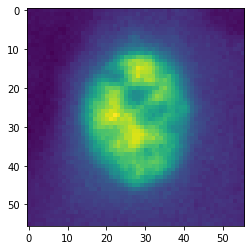

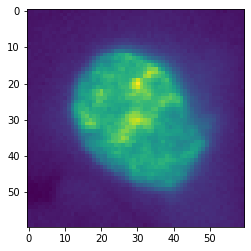

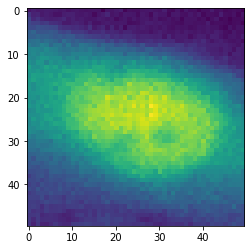

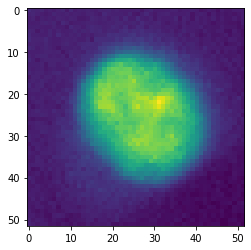

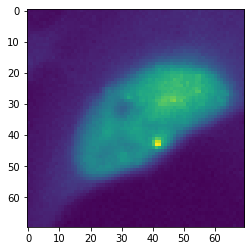

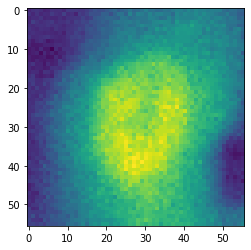

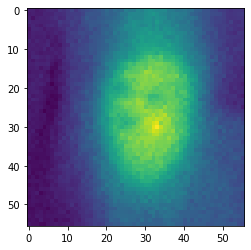

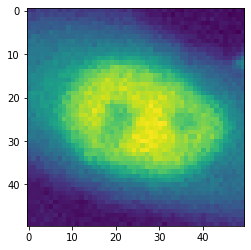

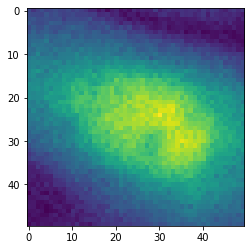

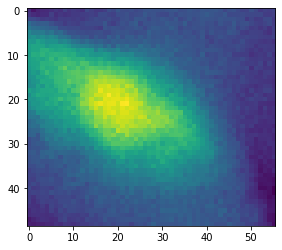

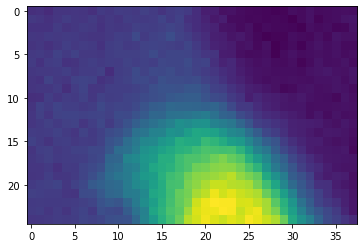

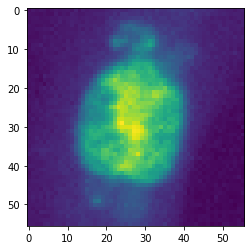

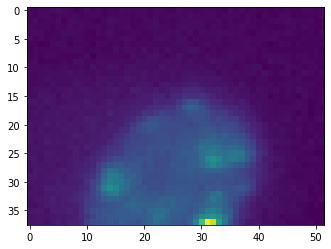

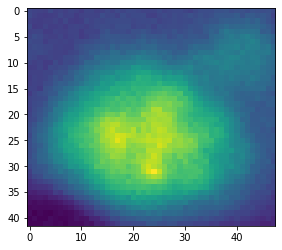

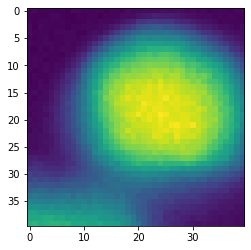

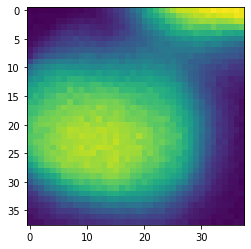

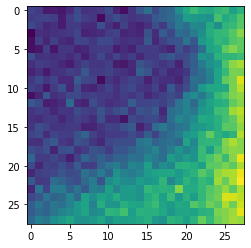

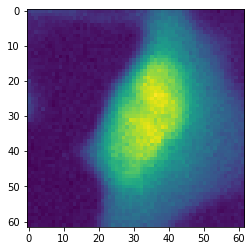

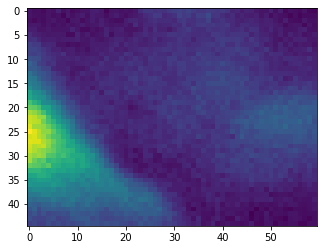

In [50]:
#lets make a display function to display them side by side easily
#then we can make an overall function that does both, getting the masks and calculating it all
#would be interesting to rank the images by most dissimilar and most similar to see which ones it did well on and which ones it failed on
#after being done with this function, I should go on to making the functions for the quantitative comparison with CellPose's base functions
for pair in pairs_test:
    plt.subplot(len(pairs_test),2,1)
    plt.imshow(pair[0])
    plt.subplot(len(pairs_test),2,1)

In [15]:
#Get the crops of the groundtruth and the crops of the prediction, both of the first mask of the test images
#this is code we'll later on want to add to crop_cells or some other python file to keep this notebook clean
import numpy as np
pred = np.copy(predicted_test_masks[0])
gt = np.copy(test_labels[0])

#So actually, I changed get_img_crops to just take the image and get the coordinates from there instead of having to input your own coordinates
#This is a mistake because we would want the coordinates to be found from the mask and then applied to a different image
#This needs to be fixed
pred_crops = get_img_crops(pred)
gt_crops = get_img_crops(gt)


#Use the iou mathcing CellPose method to match them together and display all of them next to each other with their index

In [16]:
#match up the crops
from cellpose import metrics
ious = metrics.mask_ious(gt,pred)
#print(ious)

#in this following list, each element corresponds to the predicted masks cells in order and their number is the one that they match up to in the predictions
#if the first element is 12, the first crop of the groundtruth corresponds to the 11th (12-1, counting from 0) crop from the prediction
index_match_gt_to_pred = ious[1]
print(index_match_gt_to_pred)
pairs = []
for i in range(len(index_match_gt_to_pred)):
    print(i)
    print(gt_crops[i])
    new_pair = (gt_crops[i],pred_crops[index_match_gt_to_pred[i]-1])
    pairs.append(new_pair)

[ 1  2  3  0  4  5  7  9 10 11 12 13 14 15 16 17 19 18 20 21  0 22 23 24
 25  0  0 26 27 28 29 30  0 32 31 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 48 49  0 51 52 53 54 55 56 57 58 59 60 61 63 62 64 65 66 67 68 69 70
 71 72 73 74 75 76 79 47 78 77  6  8  0 50  0]
0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
3
[[87 87 87 ...  0  0  0]
 [87 87 87 ...  0  0  0]
 [87 87 87 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
4
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
5
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0

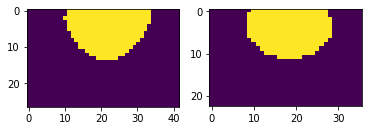

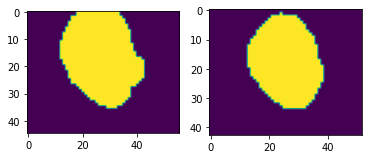

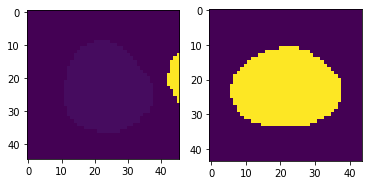

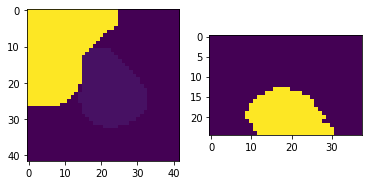

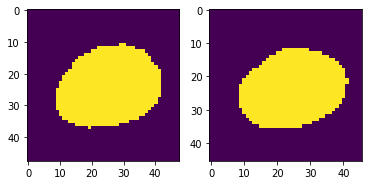

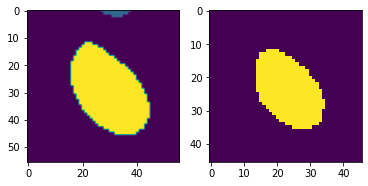

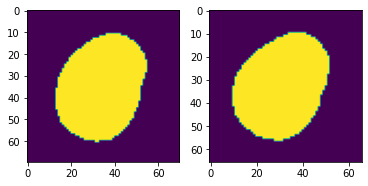

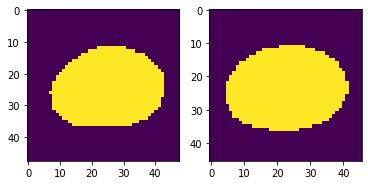

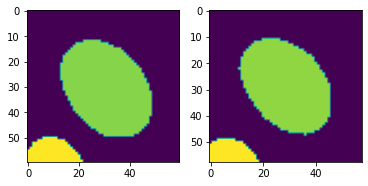

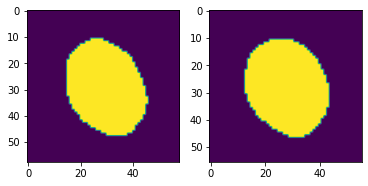

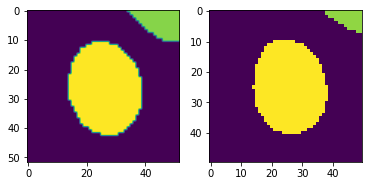

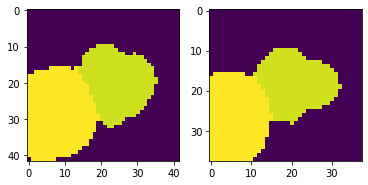

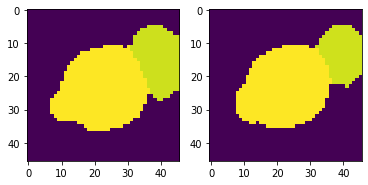

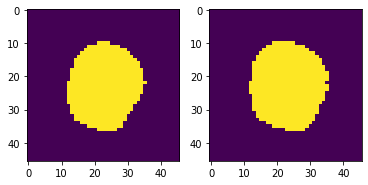

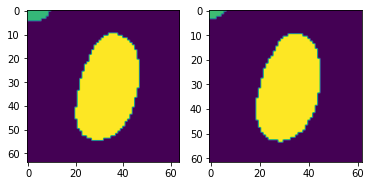

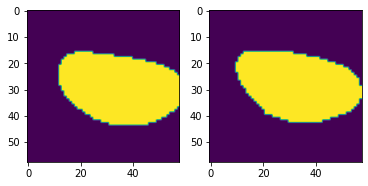

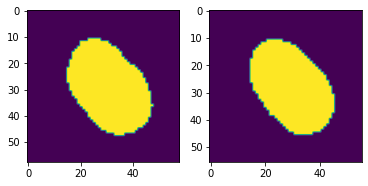

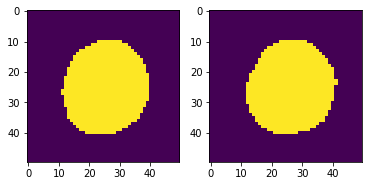

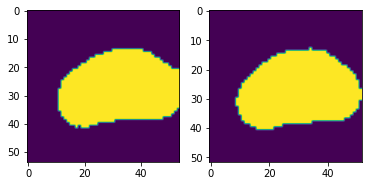

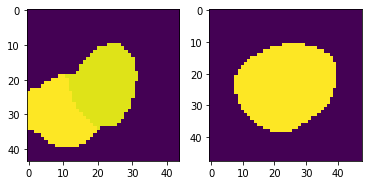

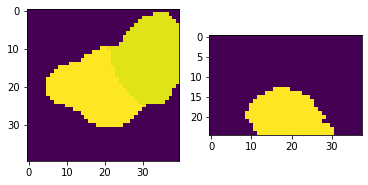

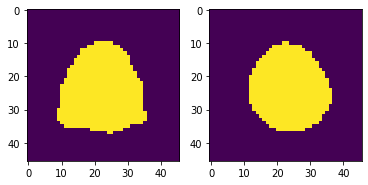

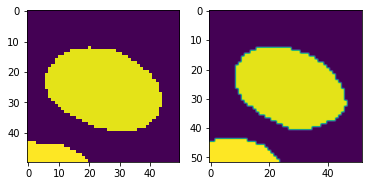

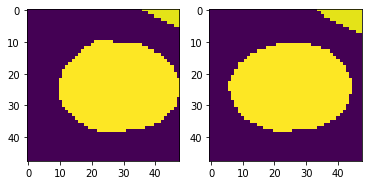

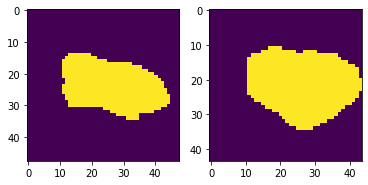

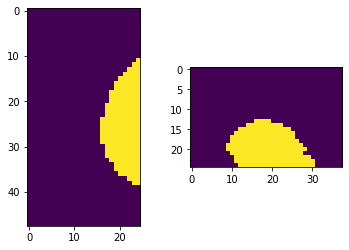

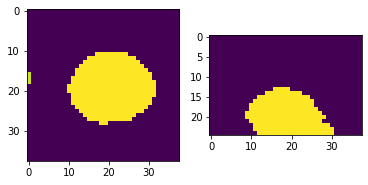

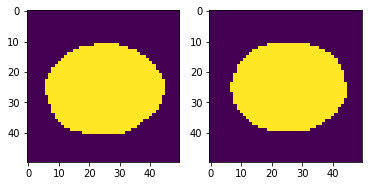

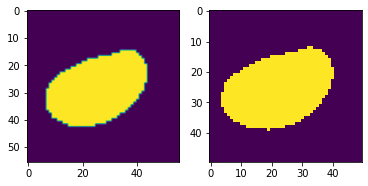

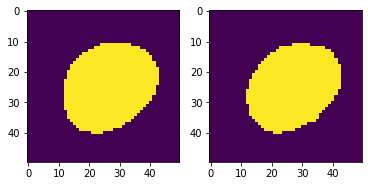

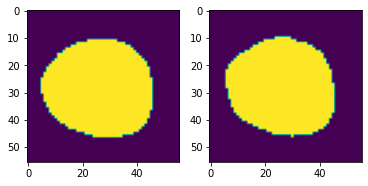

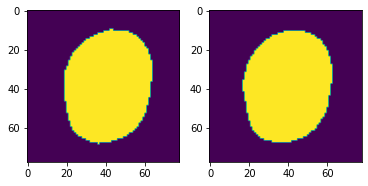

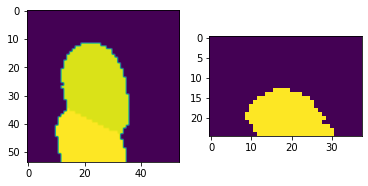

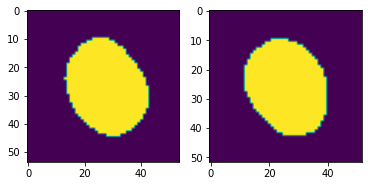

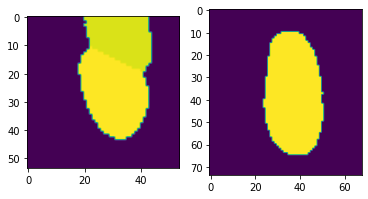

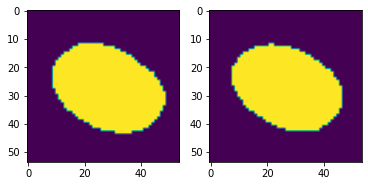

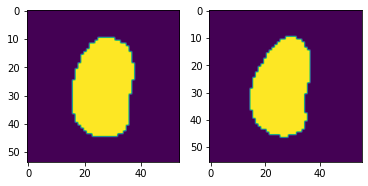

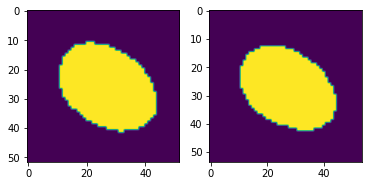

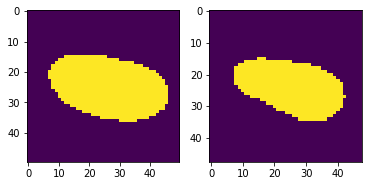

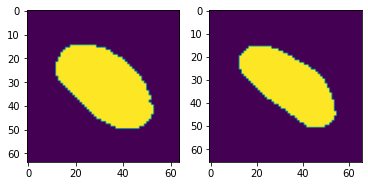

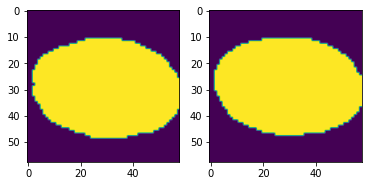

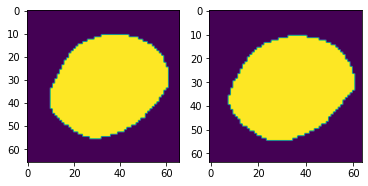

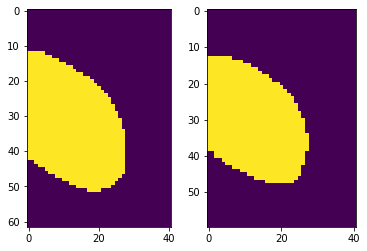

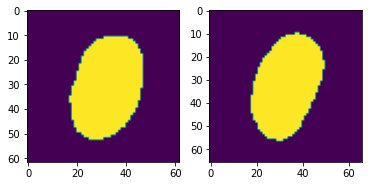

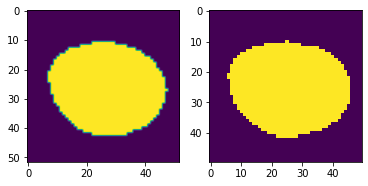

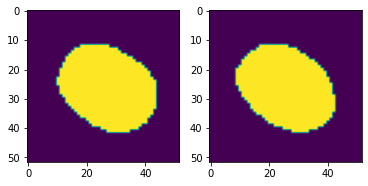

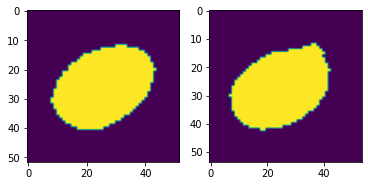

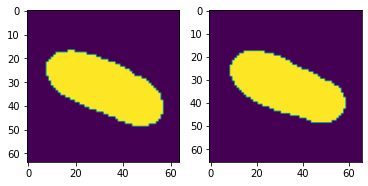

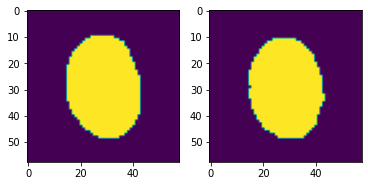

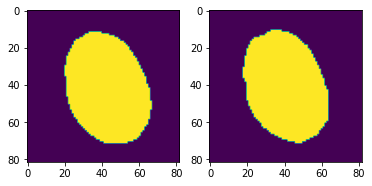

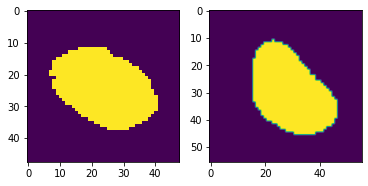

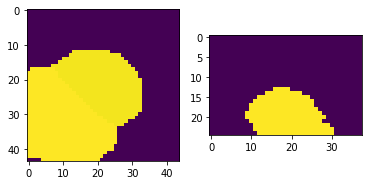

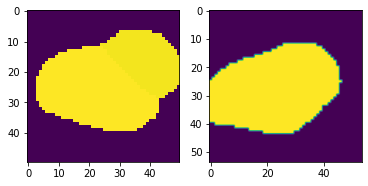

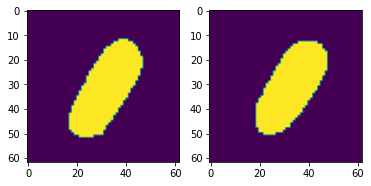

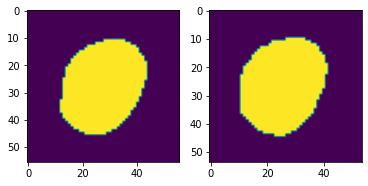

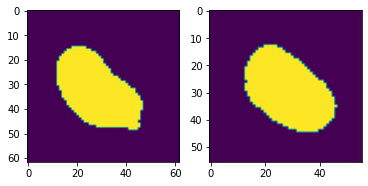

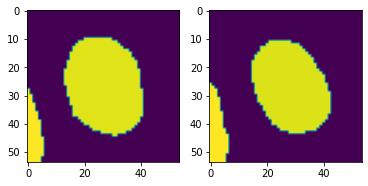

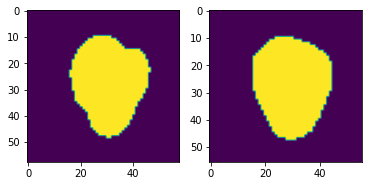

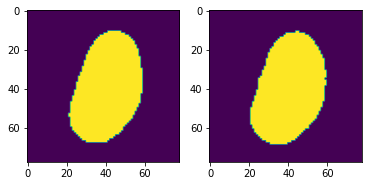

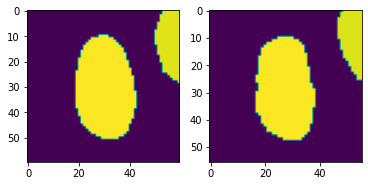

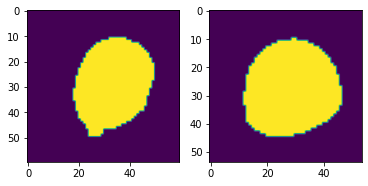

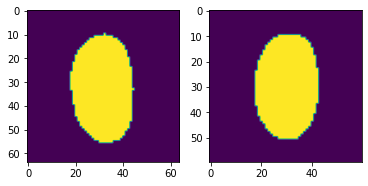

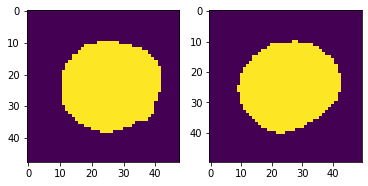

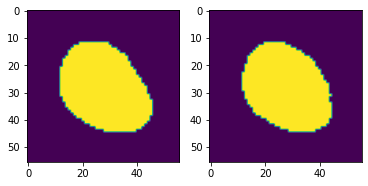

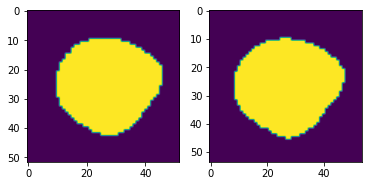

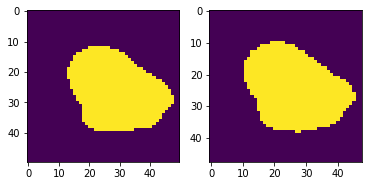

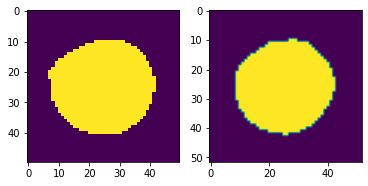

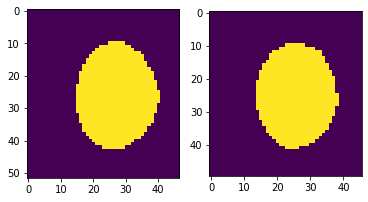

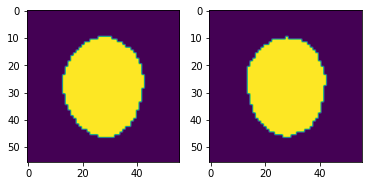

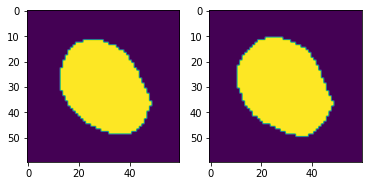

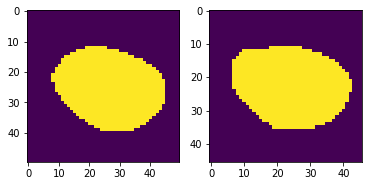

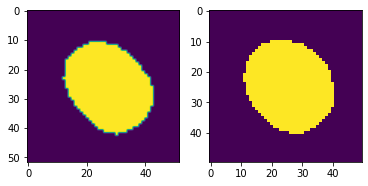

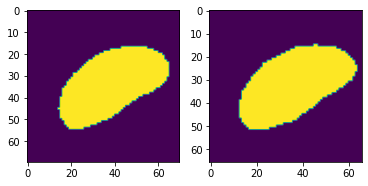

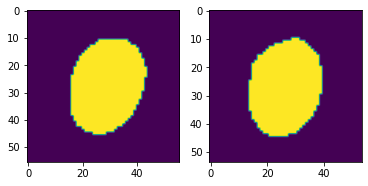

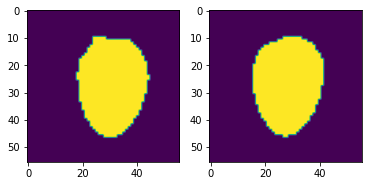

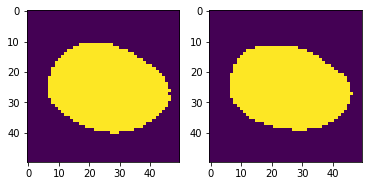

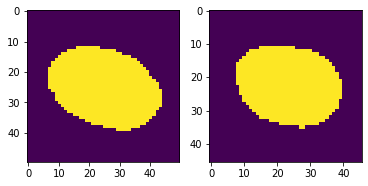

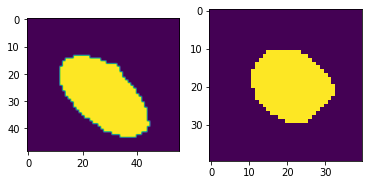

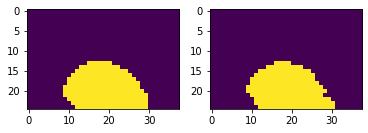

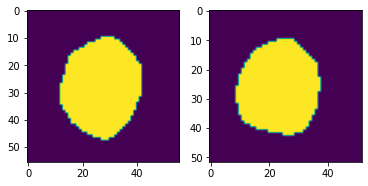

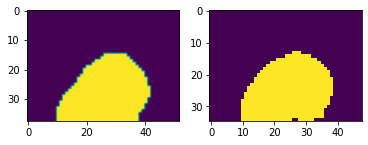

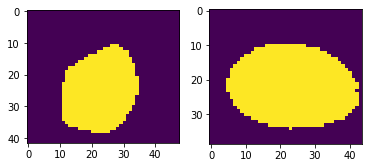

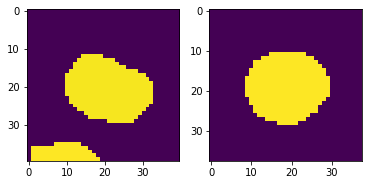

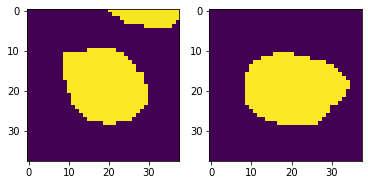

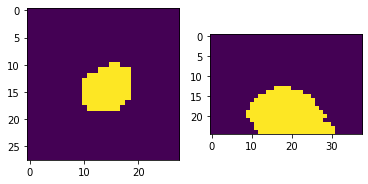

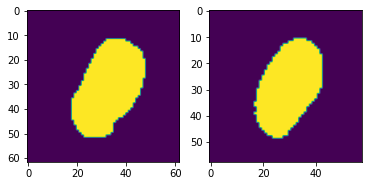

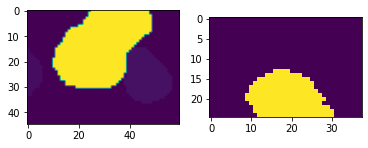

In [17]:
for pair in pairs:
    plt.subplot(121)
    plt.imshow(pair[0])
    plt.subplot(122)
    plt.imshow(pair[1])
    plt.show()

#Ok this is good but I should get these crops to be made on the real cell image, not the masks

In [ ]:
#Get the cell crop coordinates from a mask
crop_coordinates = get_cell_crop_coordinates()


#Call them on the function that gets the actual crop images with the image being the actual cell images